In [1]:
import torch
import torchvision

import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from torchsummary import summary

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import pandas as pd
import numpy as np

gpu = torch.device("cuda" if torch.cuda.is_available() else "cpu")
score_store =[]

C:\Users\posin\anaconda3\envs\pytorch\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class SignData(Dataset):
    def moveAndclean(self,df):
        
        #Move the letters behind 'j' 1 step ahead
        for i in range(df.shape[0]):
            if df['label'][i]>9:
                df['label'][i]-=1
                
        
        # remove label that is outlier.
        df = df[(df['label'] >= 0) & (df['label']<=26)]
        
        #reset index
        df.reset_index(drop=True)
        return df 
    
    def __init__(self,df):
        temp =df.iloc[:,1:].values/255.0
        temp = temp.reshape([temp.shape[0],28,28,1]).astype(np.float32)
        labels = df.iloc[:,0].values
        self.x = torch.tensor(temp)
        self.x =self.x.permute(0,3,1,2)
        self.y = torch.tensor(labels)
        self.len = df.shape[0]
        
    def __getitem__(self,rows):
        return self.x[rows],self.y[rows]
    
    def __len__(self):
        return self.len
        
        

In [3]:
def datasplit(df):
    #split data into 80 (train) / 20 (validation)
    test_set, val_set = train_test_split(df, test_size=0.2, random_state=42, stratify=df.iloc[:,0])
    test_set = test_set.reset_index(drop=True)
    val_set = val_set.reset_index(drop=True)
    return test_set,val_set

In [4]:
#reading train and test file
train = pd.read_csv('sign_mnist_train.csv')
test =  pd.read_csv('sign_mnist_test.csv')

for i in range(len(train)):
        if train['label'][i] >9:
            train['label'][i]-=1
for i in range(len(test)):
        if test['label'][i] >9:
            test['label'][i]-=1
train = train[(train['label'] >= 0) & (train['label']<=26)]
test = test[(test['label'] >= 0) & (test['label']<=26)]

print(train.shape)
Class = ['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y']
print(len(Class))

(27454, 785)
24


In [5]:
test_set, val_set = datasplit(test)

train_data = SignData(train)
train_loader = DataLoader(dataset = train_data,batch_size = 16, shuffle = True)

valid_data = SignData(val_set)
valid_loader = DataLoader(dataset = valid_data,batch_size = 16, shuffle = True)

df_merged = pd.concat([train, val_set], ignore_index=True, sort=False)
combined_data = SignData(df_merged)
combined_loader = DataLoader(dataset = combined_data,batch_size = 16, shuffle = True)

test_data = SignData(test_set)
test_loader = DataLoader(dataset = test_data,batch_size = 16, shuffle = True)

single_batch = next(iter(train_loader))
single_image = single_batch[0][0]

print('Single batch: ', single_batch[0].shape)
print('single image shape: ', single_image.shape)

Single batch:  torch.Size([16, 1, 28, 28])
single image shape:  torch.Size([1, 28, 28])


In [6]:
train.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,27454.000000,27454.000000,27454.000000,27454.000000,27454.000000,27454.000000,27454.000000,27454.000000,27454.000000,27454.000000,...,27454.000000,27454.000000,27454.000000,27454.000000,27454.000000,27454.000000,27454.000000,27454.000000,27454.000000,27454.000000
mean,11.679209,145.420267,148.501129,151.248525,153.547316,156.211700,158.412035,160.472937,162.340460,163.955526,...,141.107234,147.495665,153.324179,159.124135,161.968092,162.735558,162.904968,161.965251,161.136665,159.823450
std,6.880541,41.359046,39.942628,39.056766,38.595731,37.111598,36.126006,35.016790,33.662365,32.651980,...,63.751144,65.514087,64.428021,63.709358,63.739183,63.444883,63.510071,63.299560,63.611245,64.397669
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,121.000000,126.000000,130.000000,133.000000,137.000000,140.000000,142.000000,144.000000,146.000000,...,92.000000,96.000000,103.000000,112.000000,120.000000,125.000000,128.000000,128.000000,128.000000,125.250000
50%,12.000000,150.000000,153.000000,156.000000,158.000000,160.000000,162.000000,164.000000,165.000000,166.000000,...,144.000000,162.000000,172.000000,180.000000,183.000000,184.000000,184.000000,182.000000,182.000000,182.000000
75%,18.000000,174.000000,176.000000,178.000000,179.000000,181.000000,182.000000,183.000000,184.000000,185.000000,...,196.000000,202.000000,205.000000,207.000000,208.000000,207.000000,207.000000,206.000000,204.000000,204.000000
max,23.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


In [7]:
df_merged.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,28889.000000,28889.000000,28889.000000,28889.000000,28889.000000,28889.000000,28889.000000,28889.000000,28889.000000,28889.000000,...,28889.000000,28889.000000,28889.000000,28889.000000,28889.000000,28889.000000,28889.000000,28889.000000,28889.000000,28889.000000
mean,11.629236,145.557479,148.622071,151.372945,153.672470,156.325176,158.560352,160.567517,162.385787,164.020111,...,140.935858,147.298141,153.135796,158.875835,161.762124,162.538752,162.607152,161.697843,160.868566,159.522517
std,6.890894,41.401638,39.973009,39.064455,38.555093,37.070134,36.049618,35.035119,33.774830,32.680233,...,63.790661,65.481028,64.491255,63.839575,63.860774,63.600043,63.730817,63.505364,63.861812,64.656920
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,121.000000,126.000000,130.000000,133.000000,137.000000,140.000000,142.000000,145.000000,146.000000,...,92.000000,96.000000,102.000000,111.000000,119.000000,124.000000,127.000000,127.000000,127.000000,124.000000
50%,12.000000,150.000000,153.000000,156.000000,158.000000,160.000000,162.000000,164.000000,165.000000,166.000000,...,143.000000,162.000000,172.000000,180.000000,183.000000,184.000000,184.000000,182.000000,182.000000,181.000000
75%,18.000000,174.000000,176.000000,178.000000,180.000000,181.000000,182.000000,183.000000,184.000000,185.000000,...,196.000000,202.000000,205.000000,207.000000,208.000000,207.000000,207.000000,206.000000,205.000000,204.000000
max,23.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000


## Discover label is correct or not

torch.Size([28, 28])


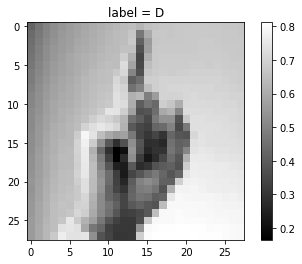

In [8]:
check = train_data[0]
image,labels = check
image =torch.squeeze(image,0)
print(image.shape)
plt.imshow(image,cmap='gray')
plt.title(f'label = {Class[labels]}')
plt.grid(False)
plt.colorbar()
plt.show()

## Build CNN

In [9]:
class cnn(nn.Module):
    
    def Cov(self,inputsize,outputsize):
        part.add(nn.BatchNorm2d(out_channels))
        part.add(nn.ReLU())
        return part
    
    def __init__(self):
        super(cnn,self).__init__()
        """
                (channel,width,height)
            Conv1
            input : (1,28,28)
            output : (32,26,26)
            
            Max pool
            input : (32,26,26)
            output:  (32,13,13)

        """
        self.Cov1 = nn.Sequential(
            nn.Conv2d(1, 32,3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        
        """
            Conv2
            input : (32,13,13)
            output: (64,11,11)
            
            Max pool
            input : (64,11,11)
            output : (64,10,10)
        """
        self.Cov2 = nn.Sequential(
            nn.Conv2d(32, 64,3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,1)
        )
        """
            Cov3
            input : (64,10,10)
            output: (128,8,8)
            
            Max pool
            input : (128,8,8)
            output : (128,7,7)
        """
        self.Cov3 = nn.Sequential(
            nn.Conv2d(64, 128,3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,1)
        )
        self.fc = nn.Linear(7*7*128, 24)
        self.dropout = nn.Dropout()
        
    def forward(self, x):
        x = self.Cov1(x)
        x = self.Cov2(x)
        x = self.Cov3(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x
        
        

In [10]:
class cnn2(nn.Module):
    
    def Cov(self,inputsize,outputsize):
        part.add(nn.BatchNorm2d(out_channels))
        part.add(nn.ReLU())
        return part
    
    def __init__(self):
        super(cnn2,self).__init__()
        """
                (channel,width,height)
            Conv1
            input : (1,28,28)
            output : (32,26,26)
            
            Max pool
            input : (32,26,26)
            output:  (32,13,13)

        """
        self.Cov1 = nn.Sequential(
            nn.Conv2d(1, 32,3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        
        """
            Conv2
            input : (32,13,13)
            output: (64,11,11)
            
            Max pool
            input : (64,11,11)
            output : (64,10,10)
        """
        self.Cov2 = nn.Sequential(
            nn.Conv2d(32, 64,3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,1)
        )
        self.fc = nn.Linear(10*10*64, 24)
        self.dropout = nn.Dropout()
        
    def forward(self, x):
        x = self.Cov1(x)
        x = self.Cov2(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [11]:
def predict(pred,label):
    _, predicted = torch.max(pred.data, 1)
    return torch.sum(predicted == label).item()

In [12]:
def training(model,learning_rate, num_epoch,input,wd,name):
    total = len(input)
    training = model.to(gpu)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(training.parameters(), lr=learning_rate)

    saving = {'train':[], 'valid':[],'train_loss':[],'valid_loss':[]}
    for epoch in range(num_epoch):
        train_loss =0.0
        correct =0.0
        for i, data in enumerate(train_loader):
            images, labels = data

            #passing image & label into gpu
            images = images.to(gpu)
            labels = labels.to(gpu)

            optimizer.zero_grad()

            outputs = training(images)
            loss = criterion(outputs, labels)


            loss.backward()
            optimizer.step()
            correct += predict(outputs,labels)
            train_loss +=loss.item()

        train_acc = correct / len(train)

        with torch.no_grad():
            valid_loss = 0.0
            val_correct = 0.0
            training.eval()

            for i, data in enumerate(valid_loader):
                images, labels = data

                #passing image & label into gpu
                images = images.to(gpu)
                labels = labels.to(gpu)

                outputs = training(images)
                loss = criterion(outputs, labels)

                valid_loss+= loss.item()
                val_correct += predict(outputs,labels)
            val_acc = val_correct / len(val_set)


        saving['train'].append(train_acc)
        saving['valid'].append(val_acc)
        saving['train_loss'].append(train_loss)
        saving['valid_loss'].append(valid_loss)
        saving['name']=name
        print(f'Epoch:{epoch+1:2d}/{num_epoch:2d}: | Train Loss: {train_loss:.4f} | Val Loss: {valid_loss:.4f}'
              f'| Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}')
    plotting(num_epoch,saving['train_loss'],saving['valid_loss'],'train loss','valid loss','Loss')
    plotting(num_epoch,saving['train'],saving['valid'],'train acc','valid acc','Accuracy')
    return saving

In [13]:
def plotting(epoch:int, input1,input2,name_1,name_2,topic):
    plt.figure(figsize=(8,5))
    plt.plot(np.arange(0,epoch),input1,label=name_1,color='r')
    plt.plot(np.arange(0,epoch),input2,label=name_2,color='b')
    plt.title(topic)
    plt.grid()
    plt.xlabel("Epoch")
    plt.ylabel(topic)
    plt.legend()
    plt.show()

In [14]:
def plotcompare(epoch:int,store):
    color =['b','g','r','c','m','y','k']
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))
    for i in range(len(store)):
        ax[0].plot(np.arange(0,epoch),store[i]['valid_loss'],label=f"{store[i]['name']} valid loss",color=color[i])
        ax[1].plot(np.arange(0,epoch),store[i]['valid'],label=f"{store[i]['name']} valid acc",color=color[i])

    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
#     plt.suptitle(f'{len(store)} models comparion')
    ax[0].legend()
    ax[1].legend()
    ax[0].grid()
    ax[1].grid()
    plt.savefig('compare.png')
    plt.show()

Epoch: 1/20: | Train Loss: 1014.4242 | Val Loss: 35.1467| Train Acc: 0.8923 | Val Acc: 0.9136
Epoch: 2/20: | Train Loss: 75.6517 | Val Loss: 23.7954| Train Acc: 0.9980 | Val Acc: 0.9296
Epoch: 3/20: | Train Loss: 20.1118 | Val Loss: 23.3961| Train Acc: 0.9999 | Val Acc: 0.9275
Epoch: 4/20: | Train Loss: 10.5912 | Val Loss: 22.7682| Train Acc: 1.0000 | Val Acc: 0.9317
Epoch: 5/20: | Train Loss: 7.0675 | Val Loss: 22.1566| Train Acc: 1.0000 | Val Acc: 0.9359
Epoch: 6/20: | Train Loss: 5.2444 | Val Loss: 22.8385| Train Acc: 1.0000 | Val Acc: 0.9331
Epoch: 7/20: | Train Loss: 4.0389 | Val Loss: 23.0010| Train Acc: 1.0000 | Val Acc: 0.9296
Epoch: 8/20: | Train Loss: 3.3087 | Val Loss: 22.7769| Train Acc: 1.0000 | Val Acc: 0.9366
Epoch: 9/20: | Train Loss: 2.7577 | Val Loss: 22.9108| Train Acc: 1.0000 | Val Acc: 0.9380
Epoch:10/20: | Train Loss: 2.3562 | Val Loss: 22.9273| Train Acc: 1.0000 | Val Acc: 0.9366
Epoch:11/20: | Train Loss: 2.0615 | Val Loss: 23.1251| Train Acc: 1.0000 | Val Acc: 

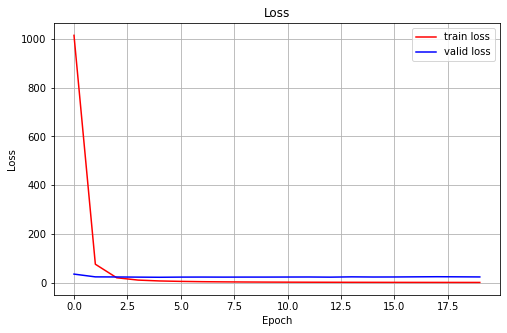

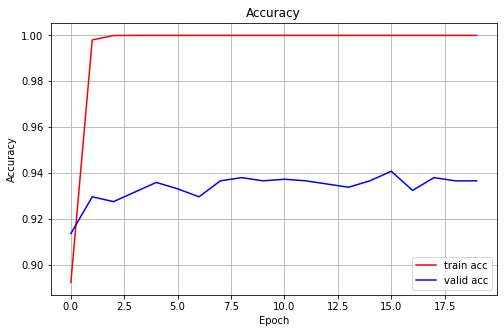

In [15]:
cnn1_w=training(cnn(),0.001,20,train_loader,0.9,'CNN_0.001')
score_store.append(cnn1_w)

Epoch: 1/20: | Train Loss: 352.8384 | Val Loss: 14.1114| Train Acc: 0.9529 | Val Acc: 0.9679
Epoch: 2/20: | Train Loss: 381.7797 | Val Loss: 17.2428| Train Acc: 0.9504 | Val Acc: 0.9436
Epoch: 3/20: | Train Loss: 2.5526 | Val Loss: 18.5714| Train Acc: 1.0000 | Val Acc: 0.9449
Epoch: 4/20: | Train Loss: 1.1602 | Val Loss: 18.8809| Train Acc: 1.0000 | Val Acc: 0.9429
Epoch: 5/20: | Train Loss: 0.7666 | Val Loss: 19.6335| Train Acc: 1.0000 | Val Acc: 0.9463
Epoch: 6/20: | Train Loss: 0.5606 | Val Loss: 19.9775| Train Acc: 1.0000 | Val Acc: 0.9449
Epoch: 7/20: | Train Loss: 0.4387 | Val Loss: 19.9272| Train Acc: 1.0000 | Val Acc: 0.9429
Epoch: 8/20: | Train Loss: 0.3582 | Val Loss: 20.6909| Train Acc: 1.0000 | Val Acc: 0.9436
Epoch: 9/20: | Train Loss: 0.3056 | Val Loss: 20.9605| Train Acc: 1.0000 | Val Acc: 0.9443
Epoch:10/20: | Train Loss: 0.2646 | Val Loss: 20.8456| Train Acc: 1.0000 | Val Acc: 0.9422
Epoch:11/20: | Train Loss: 0.2326 | Val Loss: 21.3082| Train Acc: 1.0000 | Val Acc: 0.

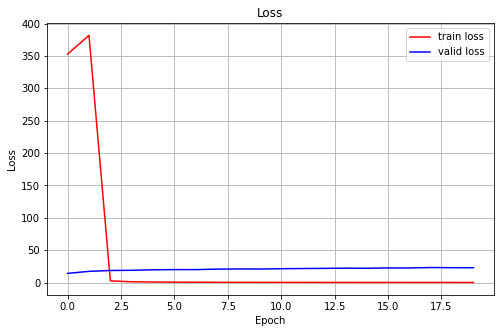

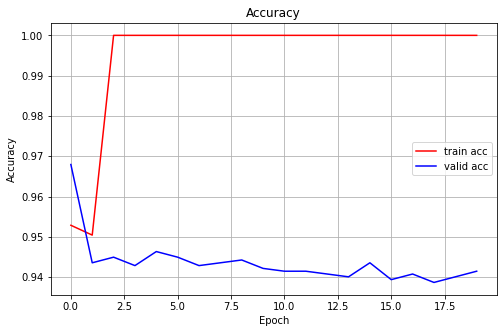

In [16]:
cnn_score = training(cnn(),0.005,20,train_loader,0.9,'CNN')
score_store.append(cnn_score)

Epoch: 1/20: | Train Loss: 390.9233 | Val Loss: 22.3930| Train Acc: 0.9489 | Val Acc: 0.9282
Epoch: 2/20: | Train Loss: 12.4354 | Val Loss: 23.1606| Train Acc: 1.0000 | Val Acc: 0.9233
Epoch: 3/20: | Train Loss: 3.8507 | Val Loss: 24.5951| Train Acc: 1.0000 | Val Acc: 0.9206
Epoch: 4/20: | Train Loss: 2.3235 | Val Loss: 25.5817| Train Acc: 1.0000 | Val Acc: 0.9233
Epoch: 5/20: | Train Loss: 1.5774 | Val Loss: 26.0724| Train Acc: 1.0000 | Val Acc: 0.9192
Epoch: 6/20: | Train Loss: 1.1841 | Val Loss: 26.4368| Train Acc: 1.0000 | Val Acc: 0.9206
Epoch: 7/20: | Train Loss: 0.9569 | Val Loss: 26.1768| Train Acc: 1.0000 | Val Acc: 0.9240
Epoch: 8/20: | Train Loss: 0.8087 | Val Loss: 27.4247| Train Acc: 1.0000 | Val Acc: 0.9233
Epoch: 9/20: | Train Loss: 0.6936 | Val Loss: 27.6417| Train Acc: 1.0000 | Val Acc: 0.9240
Epoch:10/20: | Train Loss: 0.5963 | Val Loss: 27.6985| Train Acc: 1.0000 | Val Acc: 0.9233
Epoch:11/20: | Train Loss: 0.5309 | Val Loss: 27.5145| Train Acc: 1.0000 | Val Acc: 0.9

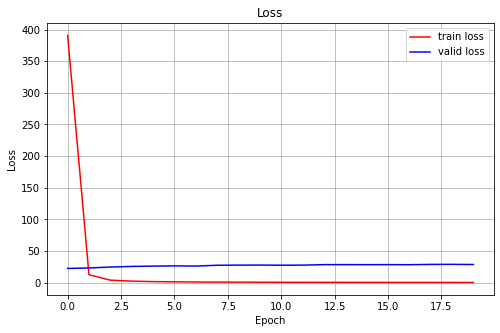

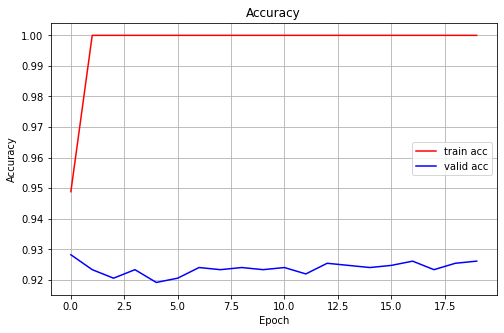

In [17]:
cnn2_score=training(cnn2(),0.005,20,train_loader,0.9,'CNN2')
score_store.append(cnn2_score)

Epoch: 1/20: | Train Loss: 1055.7079 | Val Loss: 42.0906| Train Acc: 0.8859 | Val Acc: 0.8885
Epoch: 2/20: | Train Loss: 108.3160 | Val Loss: 29.5412| Train Acc: 0.9972 | Val Acc: 0.9017
Epoch: 3/20: | Train Loss: 33.3140 | Val Loss: 28.1443| Train Acc: 1.0000 | Val Acc: 0.9073
Epoch: 4/20: | Train Loss: 18.3061 | Val Loss: 27.7191| Train Acc: 1.0000 | Val Acc: 0.9094
Epoch: 5/20: | Train Loss: 12.2652 | Val Loss: 27.5622| Train Acc: 1.0000 | Val Acc: 0.9136
Epoch: 6/20: | Train Loss: 9.0298 | Val Loss: 27.9987| Train Acc: 1.0000 | Val Acc: 0.9115
Epoch: 7/20: | Train Loss: 7.0795 | Val Loss: 28.3485| Train Acc: 1.0000 | Val Acc: 0.9143
Epoch: 8/20: | Train Loss: 5.7767 | Val Loss: 28.9846| Train Acc: 1.0000 | Val Acc: 0.9122
Epoch: 9/20: | Train Loss: 4.8412 | Val Loss: 29.4621| Train Acc: 1.0000 | Val Acc: 0.9150
Epoch:10/20: | Train Loss: 4.1621 | Val Loss: 28.9059| Train Acc: 1.0000 | Val Acc: 0.9185
Epoch:11/20: | Train Loss: 3.6405 | Val Loss: 29.2844| Train Acc: 1.0000 | Val Acc

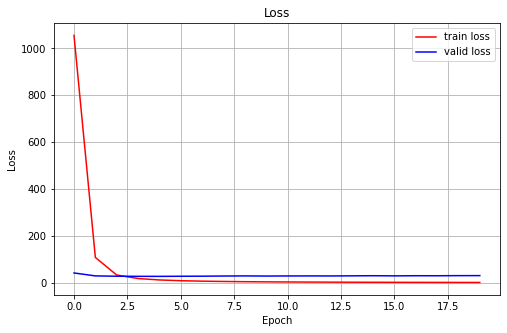

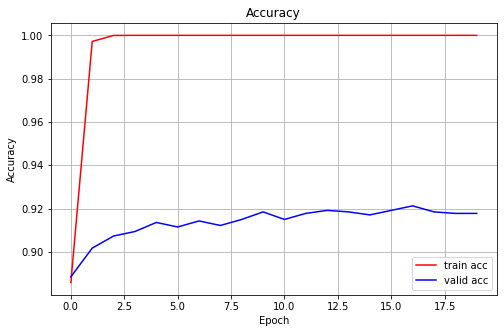

In [18]:
cnn2_w=training(cnn2(),0.001,20,train_loader,0.9,'CNN2_0.001')
score_store.append(cnn2_w)

# Without batchNorm training

In [19]:
class cnn_noBatchNorm(nn.Module):
    
    def Cov(self,inputsize,outputsize):
        part.add(nn.BatchNorm2d(out_channels))
        part.add(nn.ReLU())
        return part
    
    def __init__(self):
        super(cnn_noBatchNorm,self).__init__()
        """
                (channel,width,height)
            Conv1
            input : (1,28,28)
            output : (32,26,26)
            
            Max pool
            input : (32,26,26)
            output:  (32,13,13)

        """
        self.Cov1 = nn.Sequential(
            nn.Conv2d(1, 32,3),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        
        """
            Conv2
            input : (32,13,13)
            output: (64,11,11)
            
            Max pool
            input : (64,11,11)
            output : (64,10,10)
        """
        self.Cov2 = nn.Sequential(
            nn.Conv2d(32, 64,3),
            nn.ReLU(),
            nn.MaxPool2d(2,1)
        )
        """
            Cov3
            input : (64,10,10)
            output: (128,8,8)
            
            Max pool
            input : (128,8,8)
            output : (128,7,7)
        """
        self.Cov3 = nn.Sequential(
            nn.Conv2d(64, 128,3),
            nn.ReLU(),
            nn.MaxPool2d(2,1)
        )
        self.fc = nn.Linear(7*7*128, 24)
        self.dropout = nn.Dropout()
        
    def forward(self, x):
        x = self.Cov1(x)
        x = self.Cov2(x)
        x = self.Cov3(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

Epoch: 1/20: | Train Loss: 5431.4103 | Val Loss: 286.2112| Train Acc: 0.0523 | Val Acc: 0.0648
Epoch: 2/20: | Train Loss: 5352.9249 | Val Loss: 279.9536| Train Acc: 0.1230 | Val Acc: 0.0934
Epoch: 3/20: | Train Loss: 4872.6045 | Val Loss: 232.2742| Train Acc: 0.2160 | Val Acc: 0.1958
Epoch: 4/20: | Train Loss: 3575.5020 | Val Loss: 175.3807| Train Acc: 0.3770 | Val Acc: 0.4091
Epoch: 5/20: | Train Loss: 2623.6532 | Val Loss: 143.9676| Train Acc: 0.5442 | Val Acc: 0.5366
Epoch: 6/20: | Train Loss: 1935.0776 | Val Loss: 117.1370| Train Acc: 0.6643 | Val Acc: 0.5944
Epoch: 7/20: | Train Loss: 1429.9251 | Val Loss: 92.0671| Train Acc: 0.7519 | Val Acc: 0.6690
Epoch: 8/20: | Train Loss: 1065.3148 | Val Loss: 74.2486| Train Acc: 0.8174 | Val Acc: 0.7394
Epoch: 9/20: | Train Loss: 791.3151 | Val Loss: 65.2943| Train Acc: 0.8658 | Val Acc: 0.7387
Epoch:10/20: | Train Loss: 579.3877 | Val Loss: 54.6248| Train Acc: 0.9046 | Val Acc: 0.8098
Epoch:11/20: | Train Loss: 419.8792 | Val Loss: 49.4567|

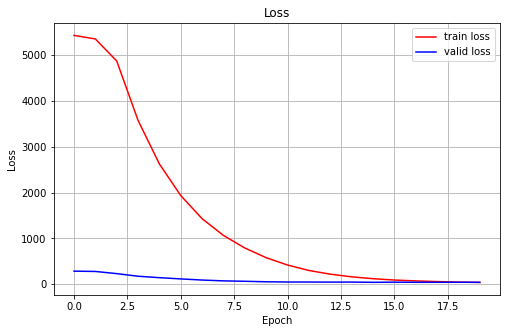

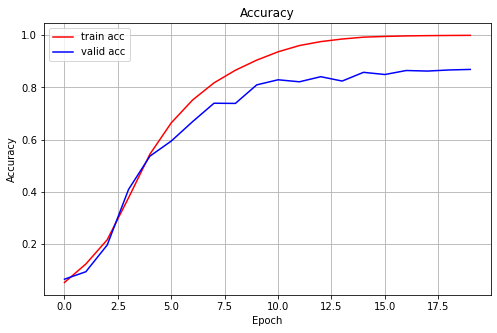

In [20]:
cnn_noBatch=training(cnn_noBatchNorm(),0.001,20,train_loader,0.9,'CNN_0.001_noBatch')
score_store.append(cnn_noBatch)

# add one more flatten layer

In [21]:
class cnn2flatten(nn.Module):
    
    def Cov(self,inputsize,outputsize):
        part.add(nn.BatchNorm2d(out_channels))
        part.add(nn.ReLU())
        return part
    
    def __init__(self):
        super(cnn2flatten,self).__init__()
        """
                (channel,width,height)
            Conv1
            input : (1,28,28)
            output : (32,26,26)
            
            Max pool
            input : (32,26,26)
            output:  (32,13,13)

        """
        self.Cov1 = nn.Sequential(
            nn.Conv2d(1, 32,3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2)
        )
        
        """
            Conv2
            input : (32,13,13)
            output: (64,11,11)
            
            Max pool
            input : (64,11,11)
            output : (64,10,10)
        """
        self.Cov2 = nn.Sequential(
            nn.Conv2d(32, 64,3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,1)
        )
        """
            Cov3
            input : (64,10,10)
            output: (128,8,8)
            
            Max pool
            input : (128,8,8)
            output : (128,7,7)
        """
        self.Cov3 = nn.Sequential(
            nn.Conv2d(64, 128,3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2,1)
        )
        self.fc = nn.Linear(7*7*128, 2500)
        self.fc2 = nn.Linear(2500,24)
        self.dropout = nn.Dropout()
        
    def forward(self, x):
        x = self.Cov1(x)
        x = self.Cov2(x)
        x = self.Cov3(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        x = self.fc2(x)
        return x

Epoch: 1/20: | Train Loss: 1487.5548 | Val Loss: 44.6369| Train Acc: 0.8423 | Val Acc: 0.8815
Epoch: 2/20: | Train Loss: 140.0686 | Val Loss: 20.6141| Train Acc: 0.9913 | Val Acc: 0.9199
Epoch: 3/20: | Train Loss: 30.6029 | Val Loss: 20.4674| Train Acc: 0.9996 | Val Acc: 0.9282
Epoch: 4/20: | Train Loss: 74.0636 | Val Loss: 19.3148| Train Acc: 0.9964 | Val Acc: 0.9373
Epoch: 5/20: | Train Loss: 14.9873 | Val Loss: 19.0122| Train Acc: 0.9998 | Val Acc: 0.9422
Epoch: 6/20: | Train Loss: 7.2544 | Val Loss: 19.8314| Train Acc: 1.0000 | Val Acc: 0.9394
Epoch: 7/20: | Train Loss: 5.0579 | Val Loss: 19.1519| Train Acc: 1.0000 | Val Acc: 0.9470
Epoch: 8/20: | Train Loss: 3.9185 | Val Loss: 19.5880| Train Acc: 1.0000 | Val Acc: 0.9422
Epoch: 9/20: | Train Loss: 3.1737 | Val Loss: 19.5262| Train Acc: 1.0000 | Val Acc: 0.9443
Epoch:10/20: | Train Loss: 2.6698 | Val Loss: 19.7036| Train Acc: 1.0000 | Val Acc: 0.9456
Epoch:11/20: | Train Loss: 2.2596 | Val Loss: 19.5780| Train Acc: 1.0000 | Val Acc

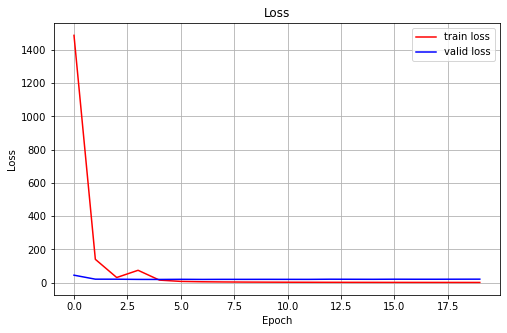

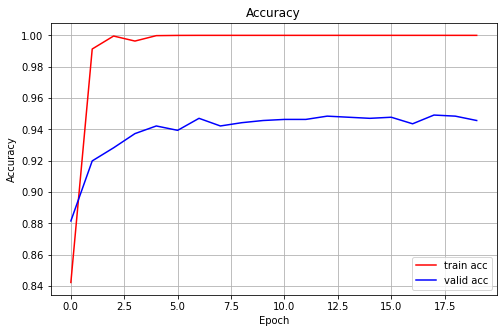

In [22]:
cnn_flatten=training(cnn2flatten(),0.001,20,train_loader,0.9,'CNN_0.001_2flatten')
score_store.append(cnn_flatten)

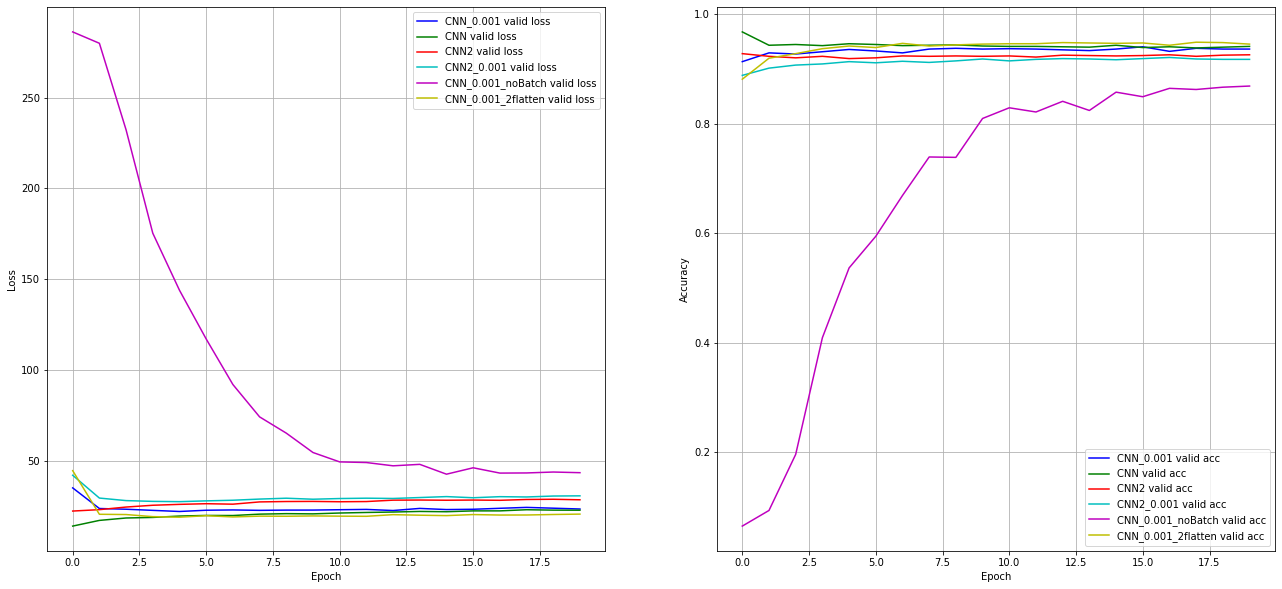

In [23]:
plotcompare(20,score_store)

In [24]:
pwd

'C:\\Users\\posin\\OneDrive\\Deeplearn\\Assignment2'

# perform unbiased

In [1]:
def early_training(model,learning_rate, num_epoch,input,wd,name,tolerance= 5):
    total = len(input)
    training = model.to(gpu)
    criterion = nn.CrossEntropyLoss()
    
    min_stopLoss = float('inf')
    tolerance_count =0
    
    optimizer = torch.optim.SGD(training.parameters(), lr=learning_rate)

    saving = {'train':[], 'valid':[],'train_loss':[],'valid_loss':[]}
    counting = 0
    for epoch in range(num_epoch):
        train_loss =0.0
        correct =0.0
        for i, data in enumerate(combined_loader):
            images, labels = data

            #passing image & label into gpu
            images = images.to(gpu)
            labels = labels.to(gpu)

            optimizer.zero_grad()

            outputs = training(images)
            loss = criterion(outputs, labels)


            loss.backward()
            optimizer.step()
            correct += predict(outputs,labels)
            train_loss +=loss.item()

        train_acc = correct / len(train)

        print(f'Epoch:{epoch+1:2d}/{num_epoch:2d}: | Train Loss: {train_loss:.4f}')
        if train_loss < min_stopLoss:
            tolerance_count=0
            min_stopLoss = train_loss
            torch.save(training.state_dict(), 'model.pth')
        else:
            tolerance_count+=1
            if tolerance_count > tolerance:
                break
        counting+=1
    saving['name']=name
    return saving

In [26]:
from sklearn.metrics import accuracy_score
def testing(model,PATH,loader,df):
    test =model
    if torch.cuda.is_available():
        test.cuda()
    test.load_state_dict(torch.load(PATH))
    val_correct =0
    
    pred =[]
    truth =[]
    
    with torch.no_grad():
        for i, data in enumerate(combined_loader):
            images, labels = data

            #passing image & label into gpu
            images = images.to(gpu)
            labels = labels.to(gpu)
            
            outputs = test(images)
            outputs =(torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            pred.extend(outputs)
            
            labels = labels.data.cpu().numpy()
            truth.extend(labels)
    print(len(truth))
    print(len(pred))
    myset = set(pred)
    check = set(truth)
    print(myset,check)
    temp=confusion_matrix(pred,truth,normalize='true')
    
    print(accuracy_score(truth, pred))
    plt.figure(figsize = (20,20))
    plt.xlabel("Predicted Classes")
    plt.ylabel("True Classes")
    sns.heatmap(temp, annot=True)
    plt.savefig('confusion.png')
    plt.show()

In [35]:
check = early_training(cnn(),0.01,20,combined_loader,0.9,'CNN_0.001')

Epoch: 1/20: | Train Loss: 354.2432
Epoch: 2/20: | Train Loss: 9.4971
Epoch: 3/20: | Train Loss: 5.3776
Epoch: 4/20: | Train Loss: 3.5908
Epoch: 5/20: | Train Loss: 2.8183
Epoch: 6/20: | Train Loss: 2.2981
Epoch: 7/20: | Train Loss: 1.9161
Epoch: 8/20: | Train Loss: 1.5877
Epoch: 9/20: | Train Loss: 1.3867
Epoch:10/20: | Train Loss: 1.2488
Epoch:11/20: | Train Loss: 1.1175
Epoch:12/20: | Train Loss: 1.0349
Epoch:13/20: | Train Loss: 0.9287
Epoch:14/20: | Train Loss: 0.8567
Epoch:15/20: | Train Loss: 0.8386
Epoch:16/20: | Train Loss: 0.7331
Epoch:17/20: | Train Loss: 0.6910
Epoch:18/20: | Train Loss: 0.6473
Epoch:19/20: | Train Loss: 0.5999
Epoch:20/20: | Train Loss: 0.5846


28889
28889
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23} {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}
1.0


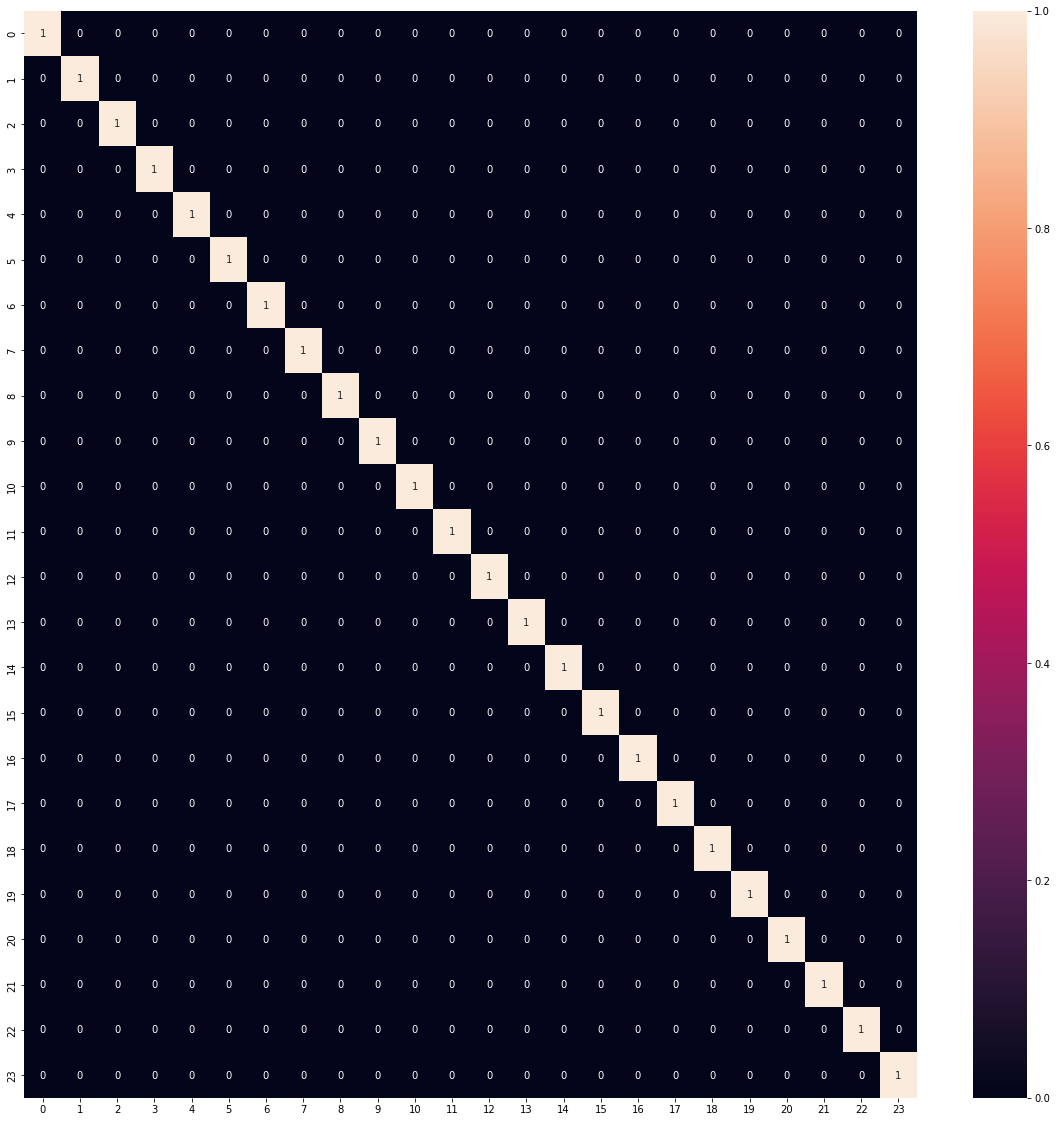

In [36]:
testing(cnn(),'model.pth',combined_loader,df_merged)